# Метрика -- количество инцидентов. 

Напомню топ-3 критериев оценки решений команд:

    1) Количество отслеживаемых событий и инцидентов

    2) Сколько инцидентов выявляется при работе с логом радиуса

    3) Точность модели/инструмента анализа


После многих вопросов и общения с оргами, я пришел к выводу, что от нас ждут только точечные инциденты. То есть ни о каких глобальных инцидентах речи не идёт. Надо, чтобы пользователь не позвонил в ростелеком. Надо выявлять инциденты по паре (время, MAC-адрес). В ноутбуке, который вы держите, делается это самое. 

In [67]:
import pandas as pd
import gzip
from collections import defaultdict, Counter
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os
import seaborn as sns
from lightgbm import LGBMRegressor

pd.options.display.float_format = '{:_.2f}'.format

agg_fields = ['tm5']

In [2]:
df_list = []
for i in tqdm(range(1, 10)):
    df_ = pd.read_csv(f'data/processed_data/processed_radius.log.{i}', parse_dates=['time'])
    df_ = df_[~df_.type.isin(['Add', 'Alive'])]
    df_list.append(df_.copy())
    del(df_)

In [3]:
df = pd.concat(df_list)
df['tm'] = df.time.astype(int) // 10**9 // 60
df['tm5'] = df['tm'] // 5

In [25]:
df_grouped = df.groupby(agg_fields)

In [26]:
sw = df_grouped.size().rename('size').to_frame()

In [27]:
df_start = df[df.type == 'Start']
df_stop = df[df.type == 'Stop']
df_failed = df[df.type == 'Failed']

# sess_duration = (df_stop.groupby('session_id').time.min() - df_start.groupby('session_id').time.max()).dropna()\
#     .dt.total_seconds().rename('duration')

In [28]:
sw['start_count'] = df_start.groupby(agg_fields).size()
sw['start_count'].fillna(0, inplace=True)
sw['stop_count'] = df_stop.groupby(agg_fields).size()
sw['stop_count'].fillna(0, inplace=True)

In [29]:
df['discon'] = (df['type'] == 'Disconnect').astype(int)
sw['discon'] = df.groupby(agg_fields)['discon'].sum()

df['failed'] = (df['type'] == 'Failed').astype(int)
sw['failed'] = df.groupby(agg_fields)['failed'].sum()

In [30]:
sw['traffic_in'] = df_grouped.traffic_in_sum.sum()
sw['traffic_out'] = df_grouped.traffic_out_sum.sum()

In [31]:
sw['delay_max'] = df_grouped['delay_max'].mean()
sw['delay_mean'] = df_grouped['delay_mean'].mean()

# Начинаем копить инциденты

In [11]:
incidents = []

### Стопы без трафика

In [12]:
q = df[(df['type'] == 'Stop') & ((df.traffic_in_sum < 1) & (df.traffic_out_sum < 1))].index
incidents += list(q)

### Строки с ненулевым error_code

In [13]:
q = df[df.error_code != 0].index
incidents += list(q)

### Строки с большим delay

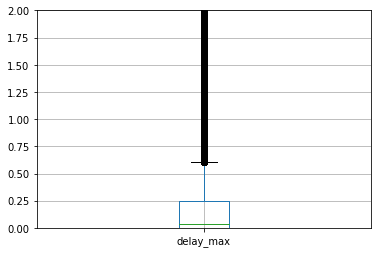

In [14]:
df.delay_max.plot.box(ylim=(0, 2), grid=True)

In [15]:
q = df[df.delay_max > 0.7].index
incidents += list(q)

### По типу "Failed"

In [16]:
q = df[df.type == 'Failed'].index
incidents += list(q)

### По частым переавторизациям (за 5 минут больше 2 попыток авторизоваться)

In [17]:
start_count = df[df.type == 'Start'].groupby(['tm5', 'client_mac']).size()

start_count_filtered = start_count[start_count > 2].rename('start_count').reset_index()

q = df.reset_index().merge(start_count_filtered, on=['tm5', 'client_mac'], how='right')['index']
incidents += list(q)

# Найденные инциденты

In [18]:
result = df.loc[set(incidents)].copy()

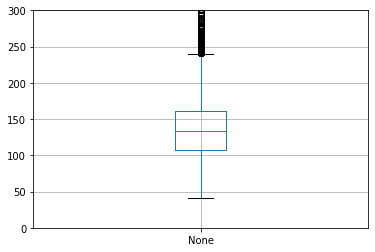

In [19]:
result.groupby('tm').size().plot.box(ylim=(0, 300), grid=True)

In [20]:
df.loc[set(incidents), 'incident'] = 1

df['incident'].fillna(0, inplace=True)

# Установка таргета

In [94]:
target_df = df.groupby('tm5')['incident'].sum()
target_df.index = target_df.index - 12

# Установка фич за последние 30 минут

In [95]:
data = pd.concat([sw, sw.shift(1), sw.shift(2), sw.shift(3), sw.shift(4), sw.shift(6)], axis=1)
data['target'] = target_df
data = data.dropna()

In [96]:
data = data.sort_index()

# Разделение на train и test 

In [97]:
n_train = int(data.shape[0] * 0.8)
train = data.iloc[:n_train]
test = data.iloc[n_train:]

In [98]:
X_train = train.drop(columns=['target']).values
y_train = train['target'].values

X_test = test.drop(columns=['target']).values
y_test = test[['target']]

In [99]:
model = LGBMRegressor()

model.fit(X_train, y_train, )

pred = model.predict(X_test)

In [100]:
y_test['pred'] = pred

/Users/g.spirov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


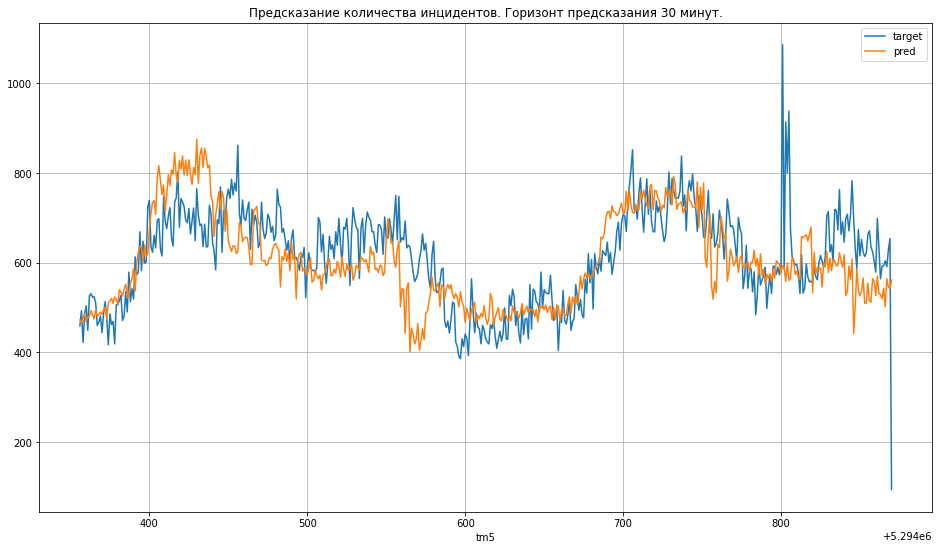

In [101]:
y_test.plot(figsize=(16, 9), grid=True)
plt.title('Предсказание количества инцидентов. Горизонт предсказания 30 минут.')
plt.savefig('pred_comparison.png', bbox_inches='tight')

In [91]:
importances = pd.Series(data=model.feature_importances_, index=data.columns[:-1])

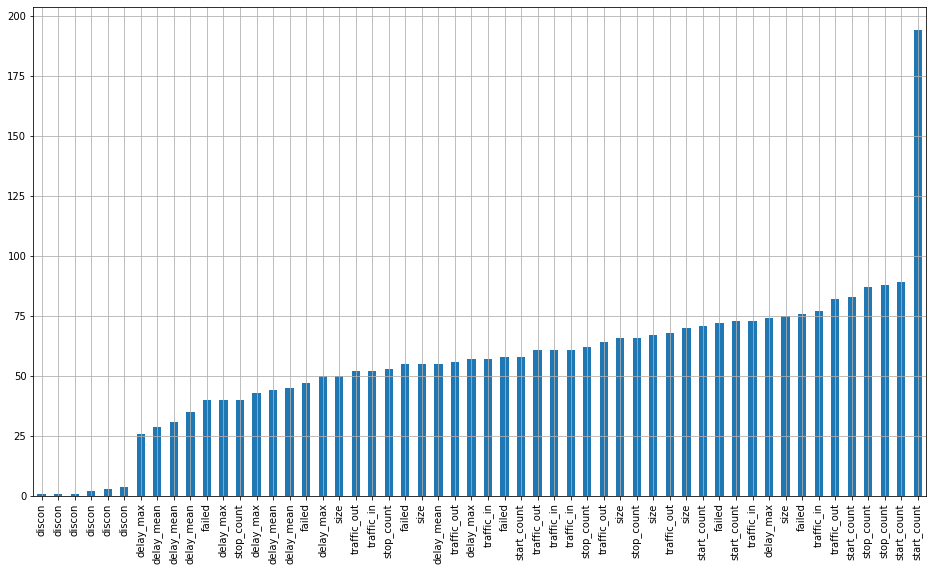

In [93]:
importances.sort_values().plot.bar(figsize=(16,9), grid=True)